In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
import time
import data
from data import select_top

def linear_regression(y, x, const = True): 
#y should be in the format of a column from dataframe
#x should be tuple of columns
    X = np.column_stack(x)
    if const:
        X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

Data = data.download()
raw_US 	=	Data['raw_US']
raw_states 	=	Data['raw_states']
raw_County 	=	Data['raw_County']
raw_Global 	=	Data['raw_Global']
fatality_rates_US = Data['fatality_rates_US']
EU 	=	Data['EU']
EU_nation 	=	Data['EU_nation']
cty_population 	=	Data['cty_population']
pop_dict 	=	Data['pop_dict']
states_D 	=	Data['states_D']
states_R 	=	Data['states_R']
US_state_neighbors 	=	Data['US_state_neighbors']
state_code 	=	Data['state_code']
new_weekly_cases_state 	=	Data['new_weekly_cases_state']
new_weekly_deaths_state 	=	Data['new_weekly_deaths_state']
percent_weekly_cases 	=	Data['percent_weekly_cases']
change_in_new_cases 	=	Data['change_in_new_cases']
new_cases_per_mil 	=	Data['new_cases_per_mil']
new_death_per_mil 	=	Data['new_death_per_mil']
cases_D 	=	Data['cases_D']
cases_R 	=	Data['cases_R']
pop_D 	=	Data['pop_D']
pop_R 	=	Data['pop_R']
wk_cases_county 	=	Data['wk_cases_county']
wk_deaths_county 	=	Data['wk_deaths_county']
cases_cty_thou 	=	Data['cases_cty_thou']


Parsing through data for US states...

Data downloaded in  15.437866926193237


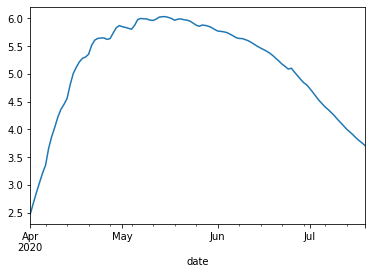

In [2]:
fatality_rates_US['2020-04-01':].plot()

<Figure size 1440x720 with 0 Axes>

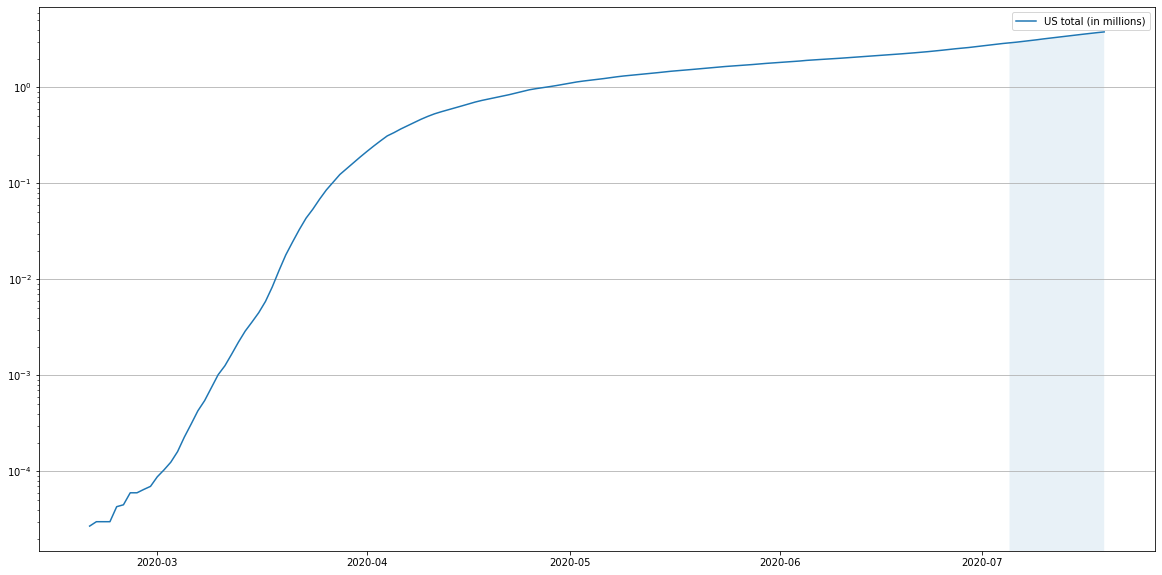

<Figure size 1440x720 with 0 Axes>

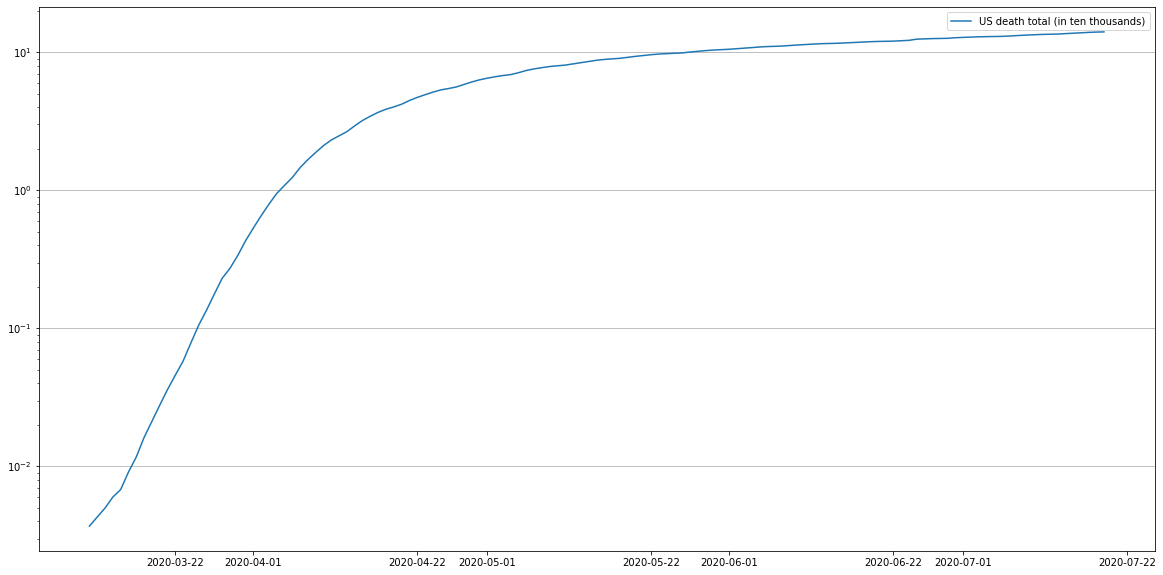

<Figure size 1080x540 with 0 Axes>

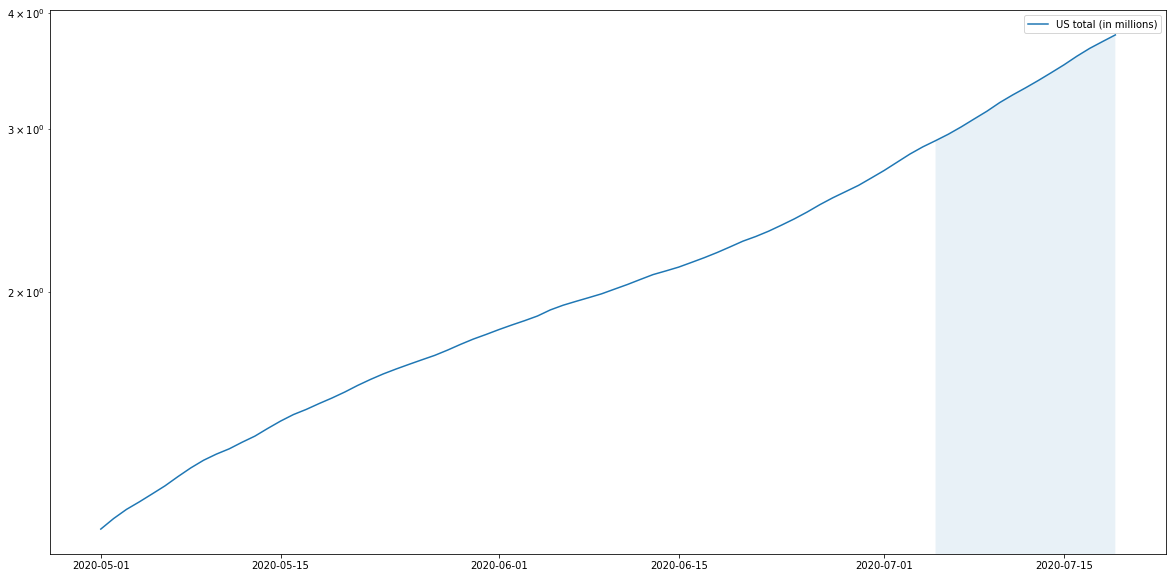

In [3]:
#####  Plot total cases
plt.figure(figsize = (20,10))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(raw_US.cases[30:]/1000000, label = "US total (in millions)" )
ax.set_yscale('log')
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, raw_US.cases[-15:]/1000000, alpha = 0.1)

#####  Plot death cases
plt.figure(figsize = (20,10))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(raw_US.deaths[50:]/10000, label = "US death total (in ten thousands)" )
ax.set_yscale('log')
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()

#####  Plot total cases
plt.figure(figsize = (15,7.5))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(raw_US.cases[-80:]/1000000, label = "US total (in millions)" )
ax.set_yscale('log')
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, raw_US.cases[-15:]/1000000, alpha = 0.1)



<Figure size 1440x720 with 0 Axes>

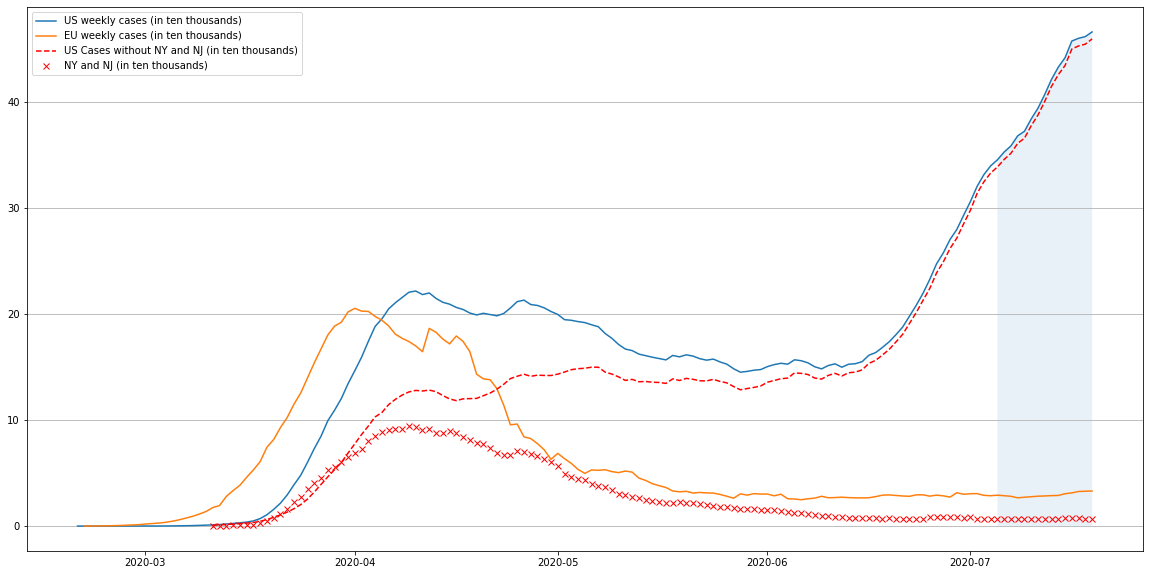

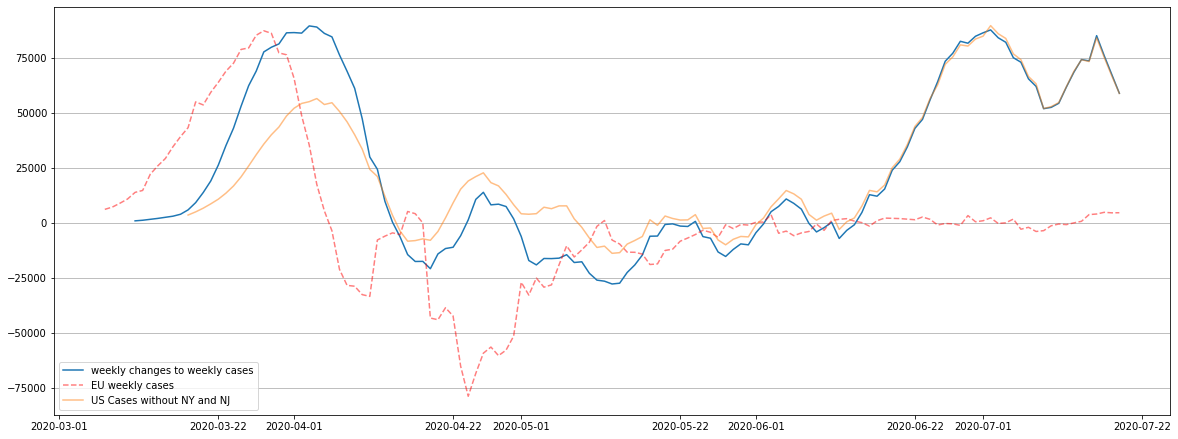

<Figure size 1440x720 with 0 Axes>

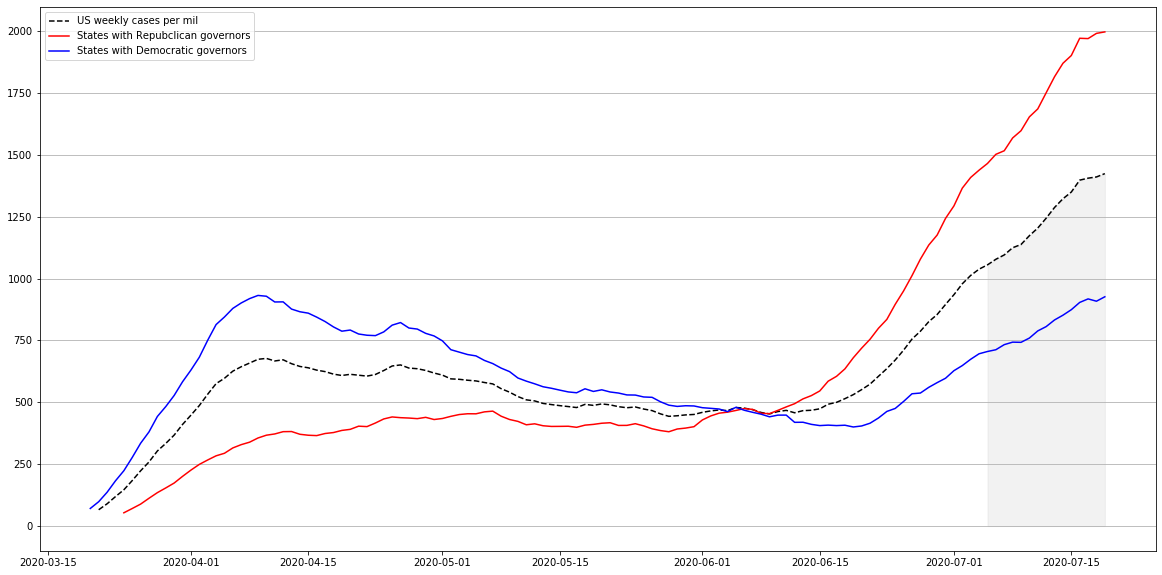

<Figure size 1440x540 with 0 Axes>

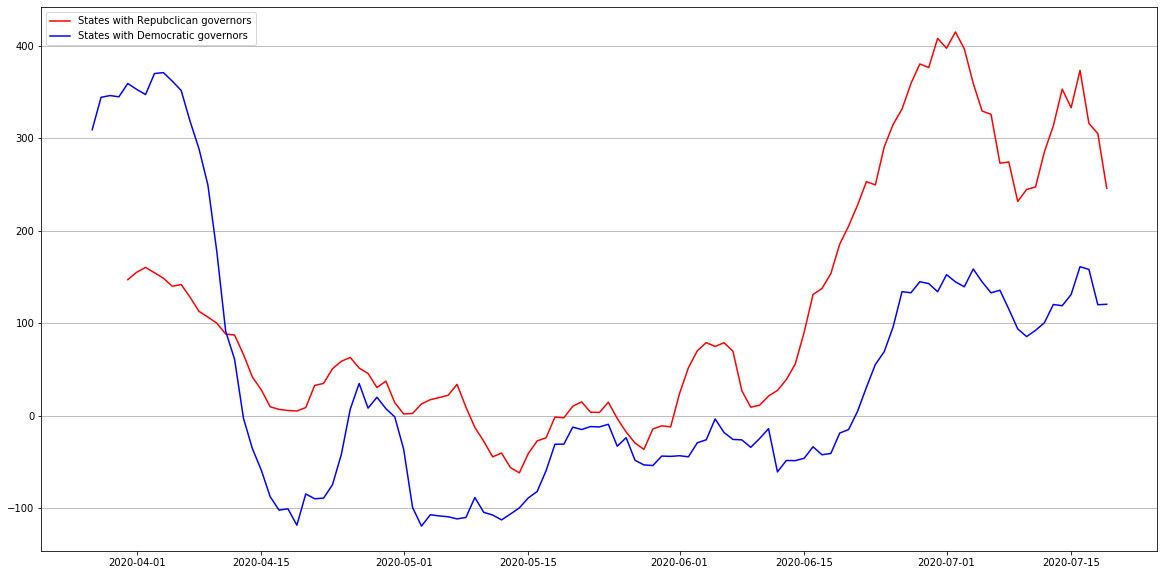

In [4]:
#####  Plot weekly cases in ten thousands for US, EU, US witout NY and NJ
plt.figure(figsize = (20,10))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(raw_US.cases.diff(7)[30:]/10000, label = "US weekly cases (in ten thousands)" )
ax.plot(raw_Global.EU.diff(7)[30:]/10000, label = "EU weekly cases (in ten thousands)")
ax.plot((raw_US.cases.diff(7) - (new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] ))[30:]/10000, 'r--', label = "US Cases without NY and NJ (in ten thousands)" )
ax.plot(((new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] ))[:]/10000, 'rx' , label = "NY and NJ (in ten thousands)" )
#plt.plot(raw_Global['US'].diff(7), label = "Global" )
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, raw_US.cases.diff(7)[-15:]/10000, alpha = 0.1)

#####  Slope of weekly cases for US and EU
plt.figure(figsize = (20,7.5))
plt.plot(raw_US.cases.diff(7).diff(7)[50:], label = "weekly changes to weekly cases" )
plt.plot(raw_Global.EU.diff(7).diff(7)[45:],'r--', label = "EU weekly cases", alpha = 0.5)
plt.plot((raw_US.cases.diff(7) - (new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] )).diff(7)[30:], label = "US Cases without NY and NJ", alpha = 0.5 )
plt.grid(axis = 'y')
plt.legend()

#####  Plot cases per mil for US, and states with a Republican or Democratic governor
plt.figure(figsize = (20,10))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(1000000*raw_US.cases.diff(7)[60:]/(pop_D + pop_R), 'r--', label = "US weekly cases per mil", color = 'Black' )
ax.plot(cases_R['cases per mil'].dropna(), label = "States with Repubclican governors", color = 'Red' )
ax.plot(cases_D['cases per mil'].dropna(), label = "States with Democratic governors", color = 'Blue')
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, 1000000*raw_US.cases.diff(7)[-15:]/(pop_D + pop_R), color = 'Grey', alpha = 0.1)

#####  Slope of cases for US, and states with a Republican or Democratic governor
plt.figure(figsize = (20,7.5))
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(cases_R['cases per mil'].diff(7).dropna(), label = "States with Repubclican governors", color = 'Red' )
ax.plot(cases_D['cases per mil'].diff(7).dropna(), label = "States with Democratic governors", color = 'Blue')
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
#ax.fill_between(raw_US.index[-15:], 0, 1000000*raw_US.cases.diff(7)[-15:]/(pop_D + pop_R), color = 'Grey', alpha = 0.1)


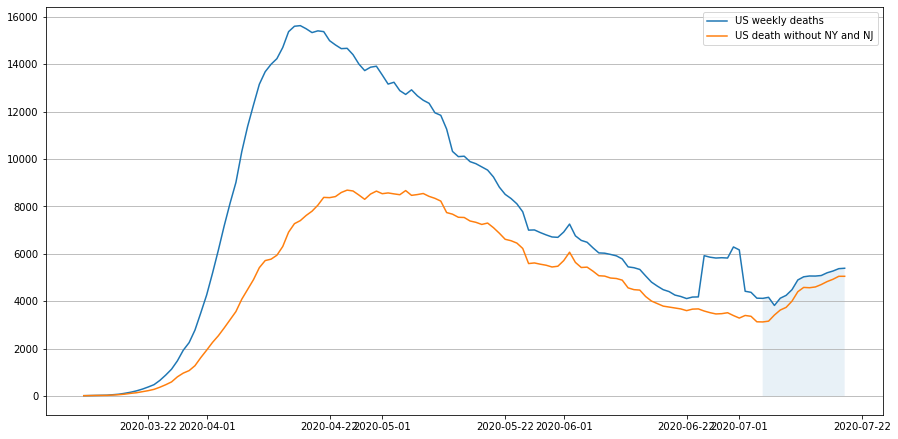

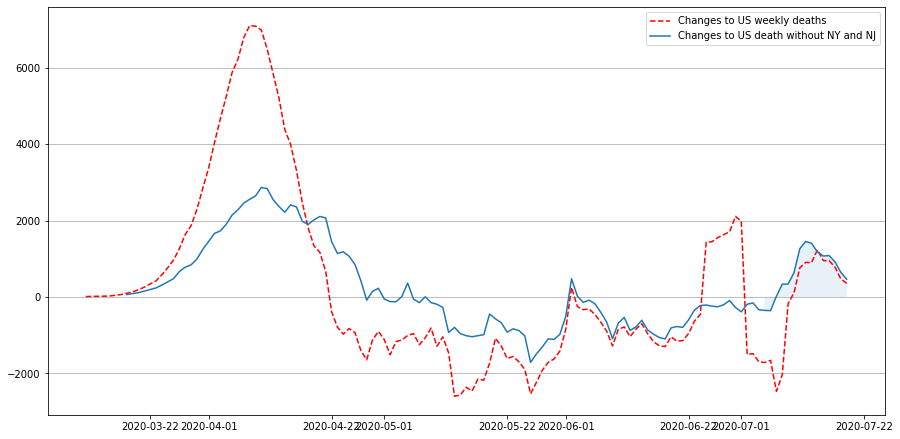

<Figure size 1080x540 with 0 Axes>

In [5]:
#####  Weekly deaths reported
fig, ax = plt.subplots(figsize = (15,7.5))
ax.plot(raw_US.deaths.diff(7)[50:], label = "US weekly deaths")
ax.plot((raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] ))[50:], label = "US death without NY and NJ" )
ax.legend()
ax.grid(axis = 'y')
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, raw_US .deaths.diff(7)[-15:], alpha = 0.1)


fig, ax = plt.subplots(figsize = (15,7.5))
plt.figure(figsize = (15,7.5))
ax.plot(raw_US.deaths.diff(7).diff(7)[50:], 'r--', label = "Changes to US weekly deaths")
ax.plot((raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] )).diff(7)[50:], label = "Changes to US death without NY and NJ" )
ax.grid(axis = 'y')
ax.legend()
ylim = ax.get_ylim()
ax.fill_between(raw_US.index[-15:], 0, (raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] )).diff(7)[-15:], alpha = 0.1)

In [6]:
US_death_normalised = raw_US.deaths.diff(7) / max(raw_US.deaths.diff(7).dropna())
US_cases_normalised = raw_US.cases.diff(7).dropna() / max(raw_US.cases.diff(7).dropna())

##############EVALUATE DATE OF MAXIMUMS FOR CASES AND DEATH IN US
print( 'death ', select_top(US_death_normalised.dropna().to_dict(), sum_list = 0, top = 1 )[0], '\t', max(raw_US.deaths.diff(7).dropna()))
print( 'cases ', select_top(US_cases_normalised.dropna().to_dict(), sum_list = 0, top = 1 )[0], '\t', max(raw_US.cases.diff(7).dropna()))



death  2020-04-17 	 15623.0
cases  2020-07-19 	 466573.0


In [7]:
change_in_new_cases

{'Washington': 55.56094015023028,
 'Illinois': 35.54249064671298,
 'California': 16.752086689119913,
 'Arizona': -12.414649286157644,
 'Massachusetts': 48.2019892884473,
 'Wisconsin': 50.02478929102639,
 'Texas': 53.51153039832292,
 'Nebraska': 37.222757955641704,
 'Utah': 18.571428571428548,
 'Oregon': 27.898358920063526,
 'Florida': 35.91029202520493,
 'New York': 12.872598807684017,
 'Rhode Island': 45.75757575757519,
 'Georgia': 34.25010485948828,
 'New Hampshire': -0.6666666666674417,
 'North Carolina': 28.54525467204101,
 'New Jersey': -31.953195319532433,
 'Colorado': 79.50276243093893,
 'Maryland': 92.26030034655372,
 'Nevada': 51.58506846745448,
 'Tennessee': 44.66410748560448,
 'Hawaii': 29.508196721311464,
 'Indiana': 61.97318007662824,
 'Kentucky': 211.52597402597414,
 'Minnesota': 51.60293549633075,
 'Oklahoma': 68.56568364611256,
 'Pennsylvania': 21.048072758770257,
 'South Carolina': 15.710939533269672,
 'District of Columbia': 76.92307692307726,
 'Kansas': 39.1992960844

['Washington', 'Texas', 'Colorado', 'Maryland', 'Nevada', 'Indiana', 'Kentucky', 'Minnesota', 'Oklahoma', 'District of Columbia', 'Missouri', 'Virginia', 'Louisiana', 'Michigan', 'North Dakota', 'Alaska', 'Alabama', 'Idaho', 'Montana', 'West Virginia']
['California', 'Arizona', 'Utah', 'Oregon', 'New York', 'Georgia', 'New Hampshire', 'North Carolina', 'New Jersey', 'Hawaii', 'Pennsylvania', 'South Carolina', 'Vermont', 'Iowa', 'South Dakota', 'Arkansas', 'Delaware', 'Mississippi', 'Wyoming', 'Maine']


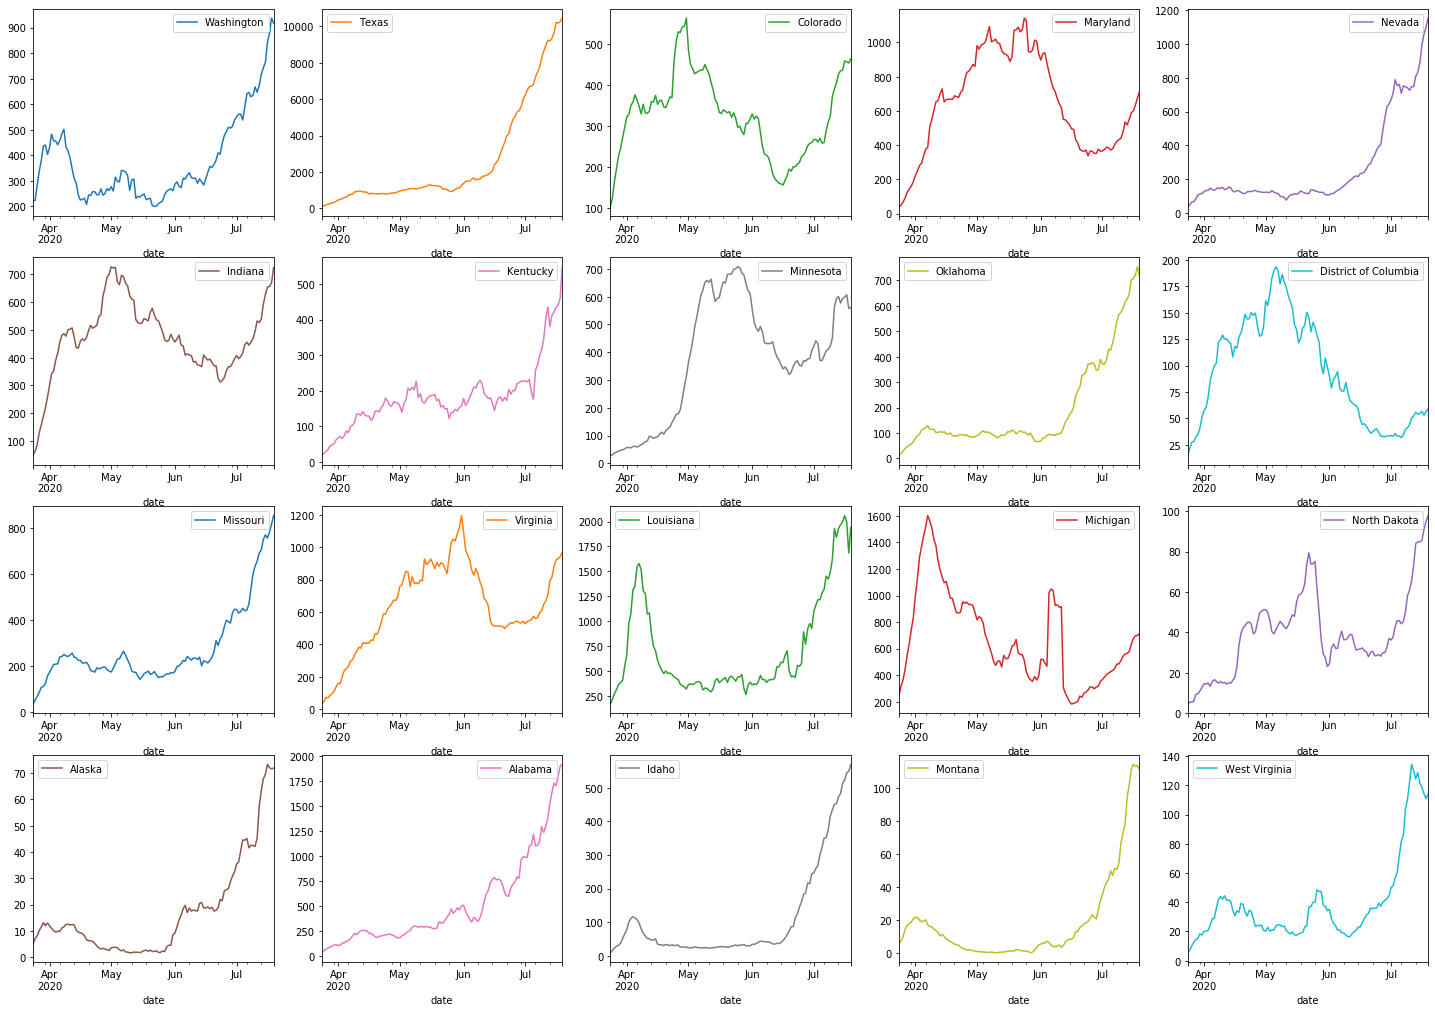

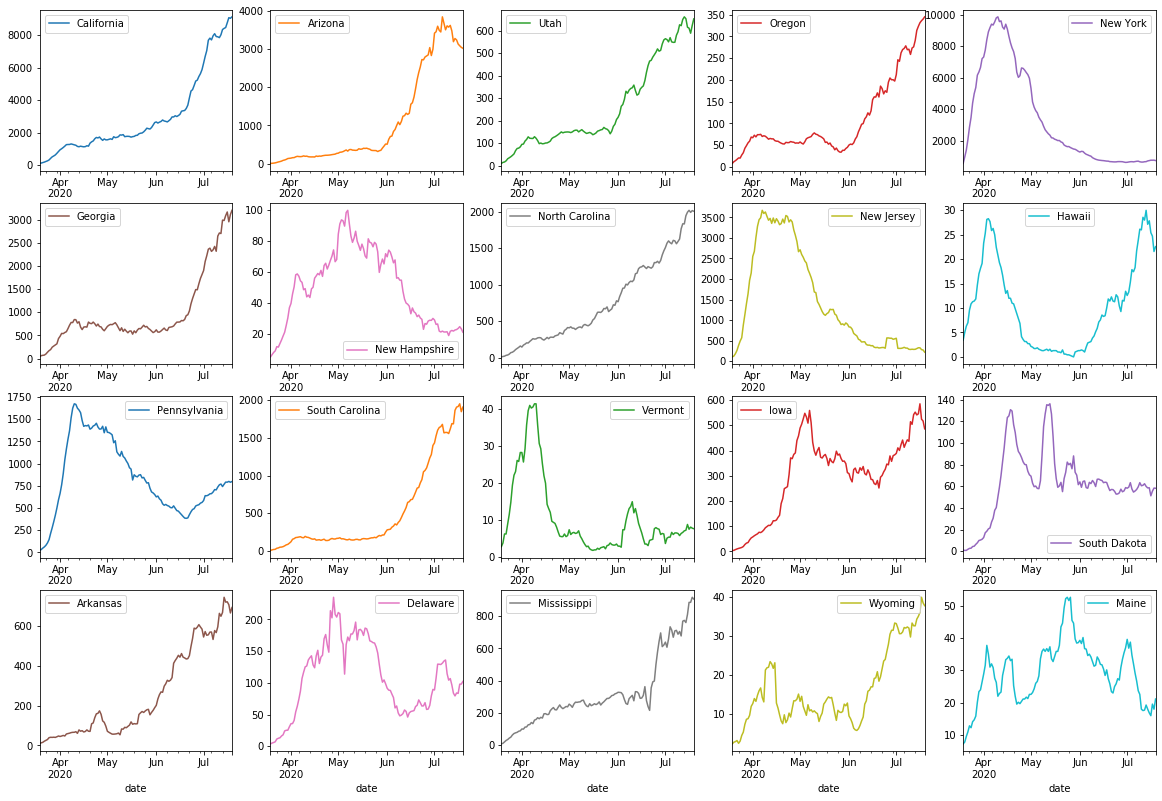

In [8]:
order = list(change_in_new_cases.values())
order.sort(reverse = True)
top_10_states = [key for key, value in change_in_new_cases.items() if value in order[:20] ]
bottom_states = [key for key, value in change_in_new_cases.items() if value in order[-20:]]
#print(select_top(change_in_new_cases, sum_list = 0), '\n')
print(top_10_states)
print(bottom_states)

top_10 = pd.DataFrame()
bottom = pd.DataFrame()
for st in top_10_states:
#    top_10[st] = new_cases_per_mil[st][-90:]
    top_10[st] = new_weekly_cases_state[st]/7
for st in bottom_states:
    bottom[st] = new_weekly_cases_state[st]/7
    
top_10.dropna(inplace = True)
top_10.plot(subplots = True, layout = (10,5), figsize = (25,45), sharex=False)

bottom.dropna(inplace = True)
bottom.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)
plt.show()

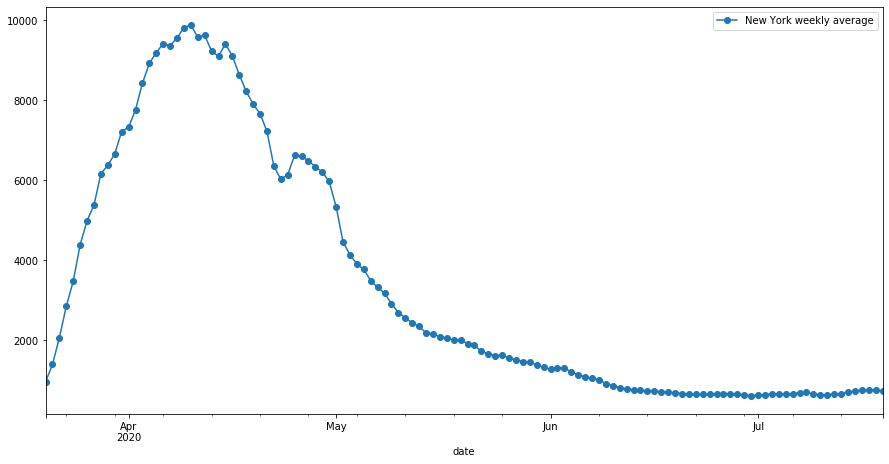

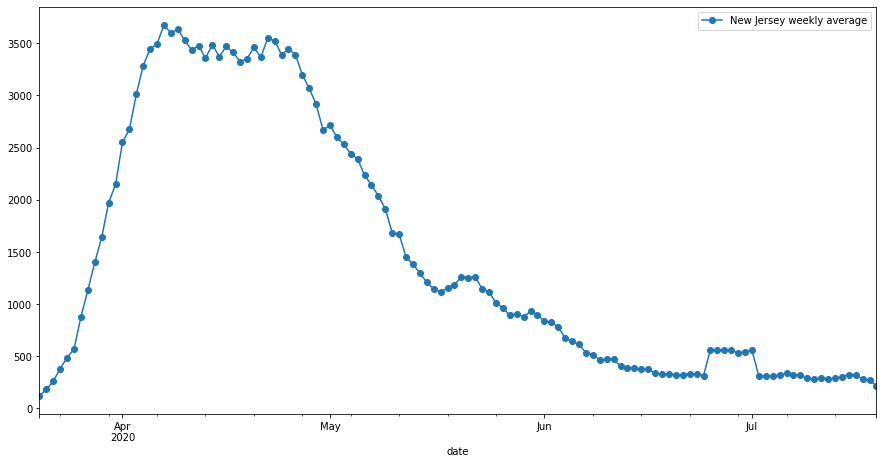

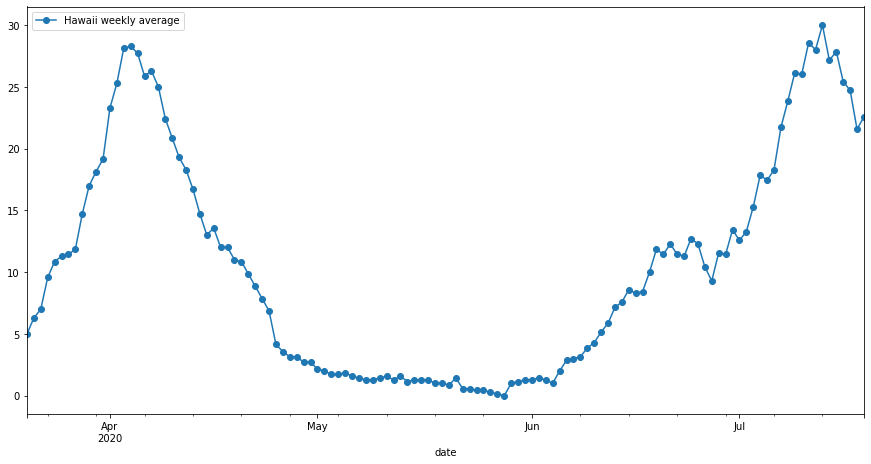

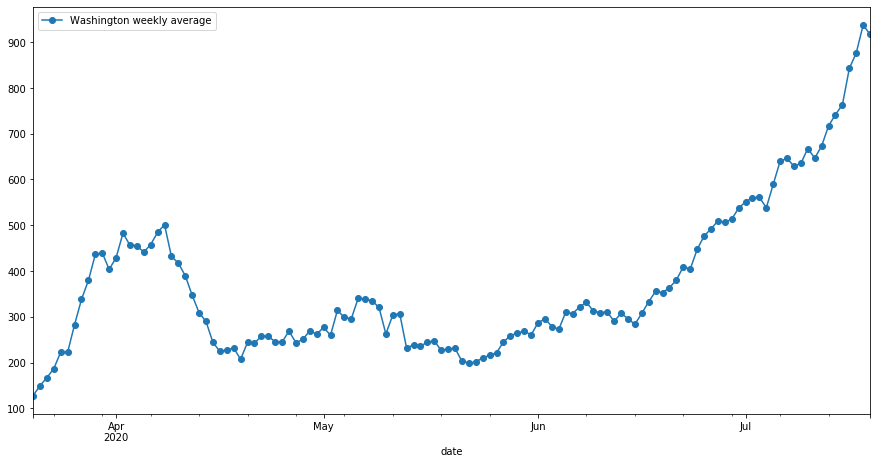

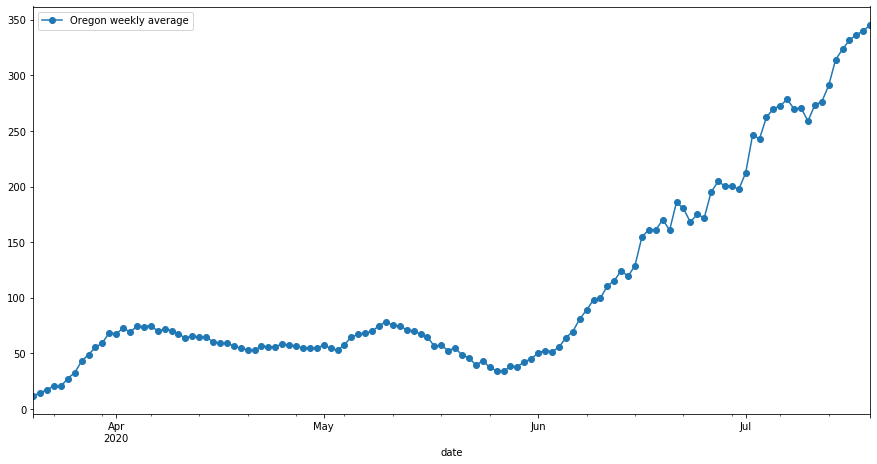

In [9]:
interested_state = ['New York', 'New Jersey', 'Hawaii', 'Washington', 'Oregon']

for st in interested_state:
    plt.figure(figsize = (15,7.5))
    (new_weekly_cases_state[st]['2020-03-20':]/7).plot(label = st + ' weekly average', marker='o')
    plt.legend()


In [10]:
def start_of_pandemic(cases, ratio = -1, limit = -1):
    if limit == -1:
        return [ date for date, val in dict(cases).items() if val >= cases.max()/ratio ][0].date() + dt.timedelta(days = -1)
    else:
        return [ date for date, val in dict(cases).items() if val >= limit ][0].date() + dt.timedelta(days = -1)

for st, cases in new_cases_per_mil.items():
    cases.dropna(inplace = True)


<Figure size 1080x720 with 0 Axes>

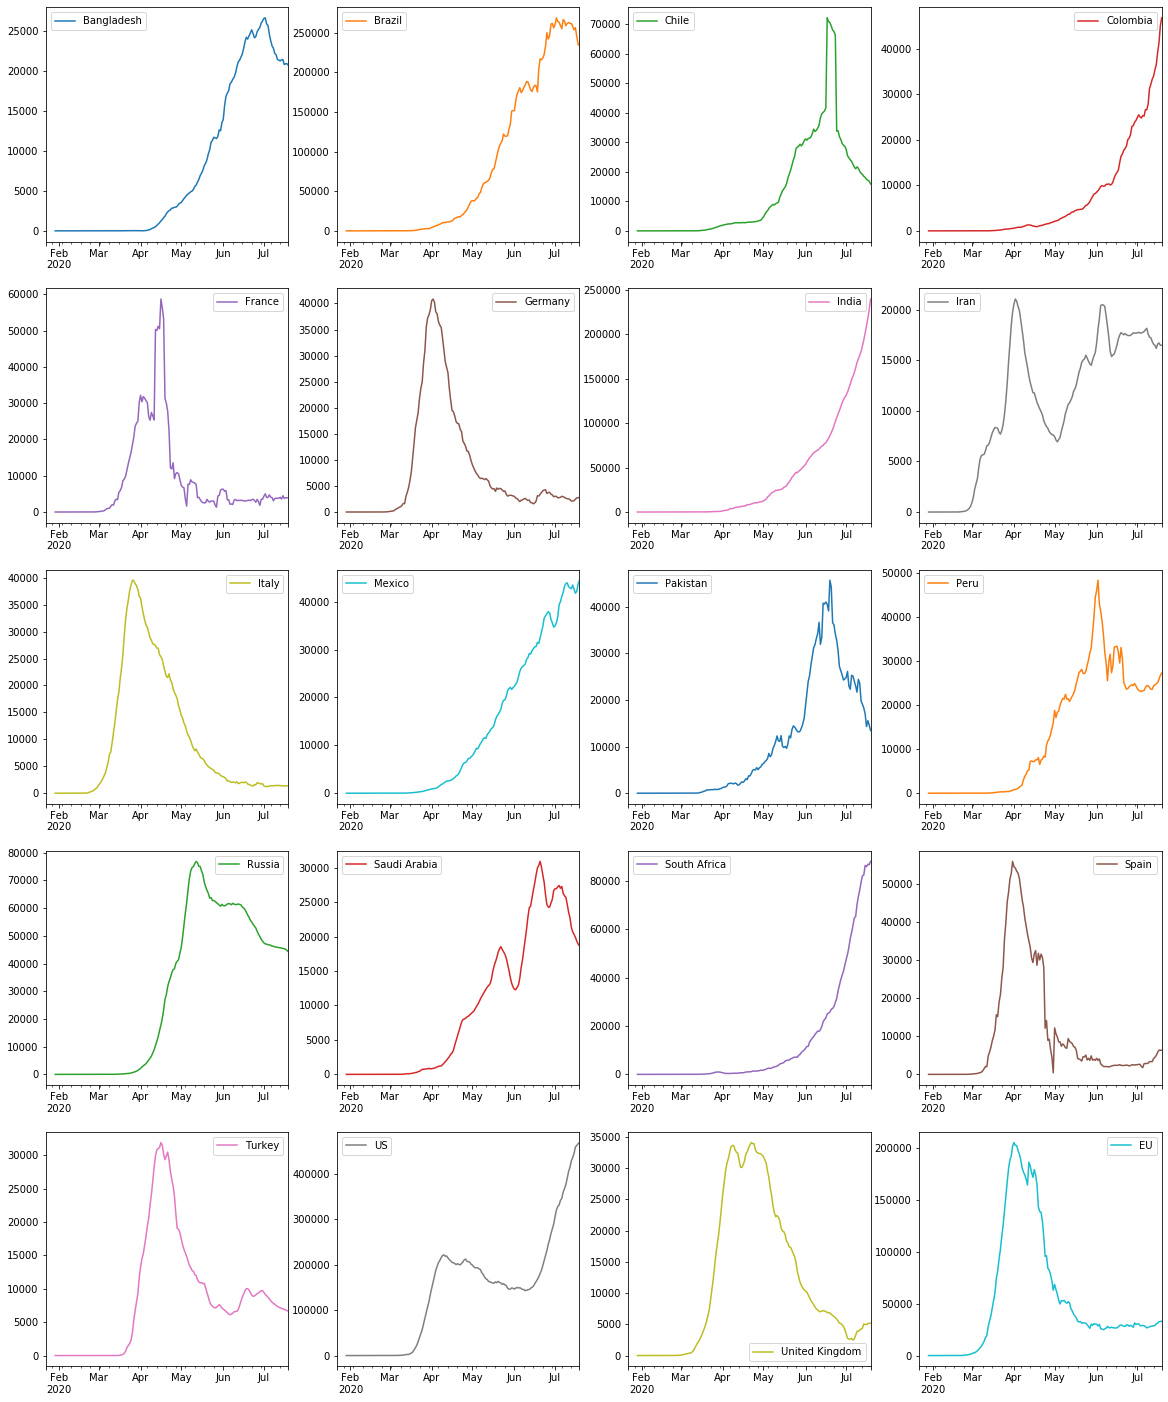

In [11]:
count_cases = raw_Global.iloc[-1].to_dict()
global_cases = list(count_cases.values())
global_cases.sort(reverse = True)
countries = [key for key, value in count_cases.items() if value in global_cases[:20]]

sliced_countries = raw_Global[countries]
plt.figure(figsize = (15,10))
sliced_countries.diff(7).plot(subplots = True, layout = (5,4), figsize = (20,25), sharex=False)
plt.show()

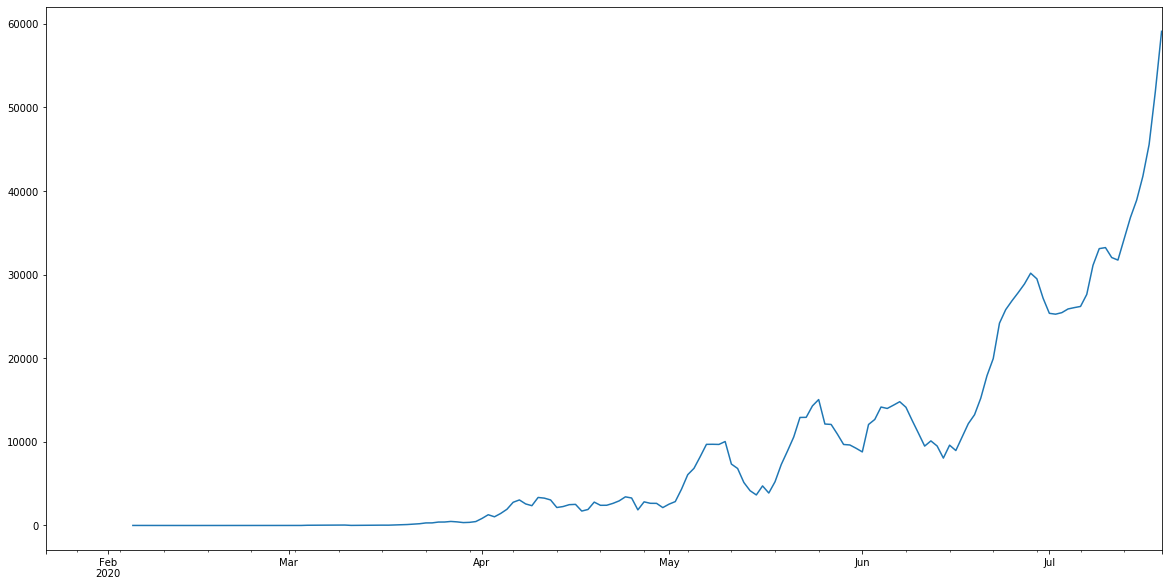

In [12]:
raw_Global['India'].diff(7).diff(7).plot(figsize = (20,10))

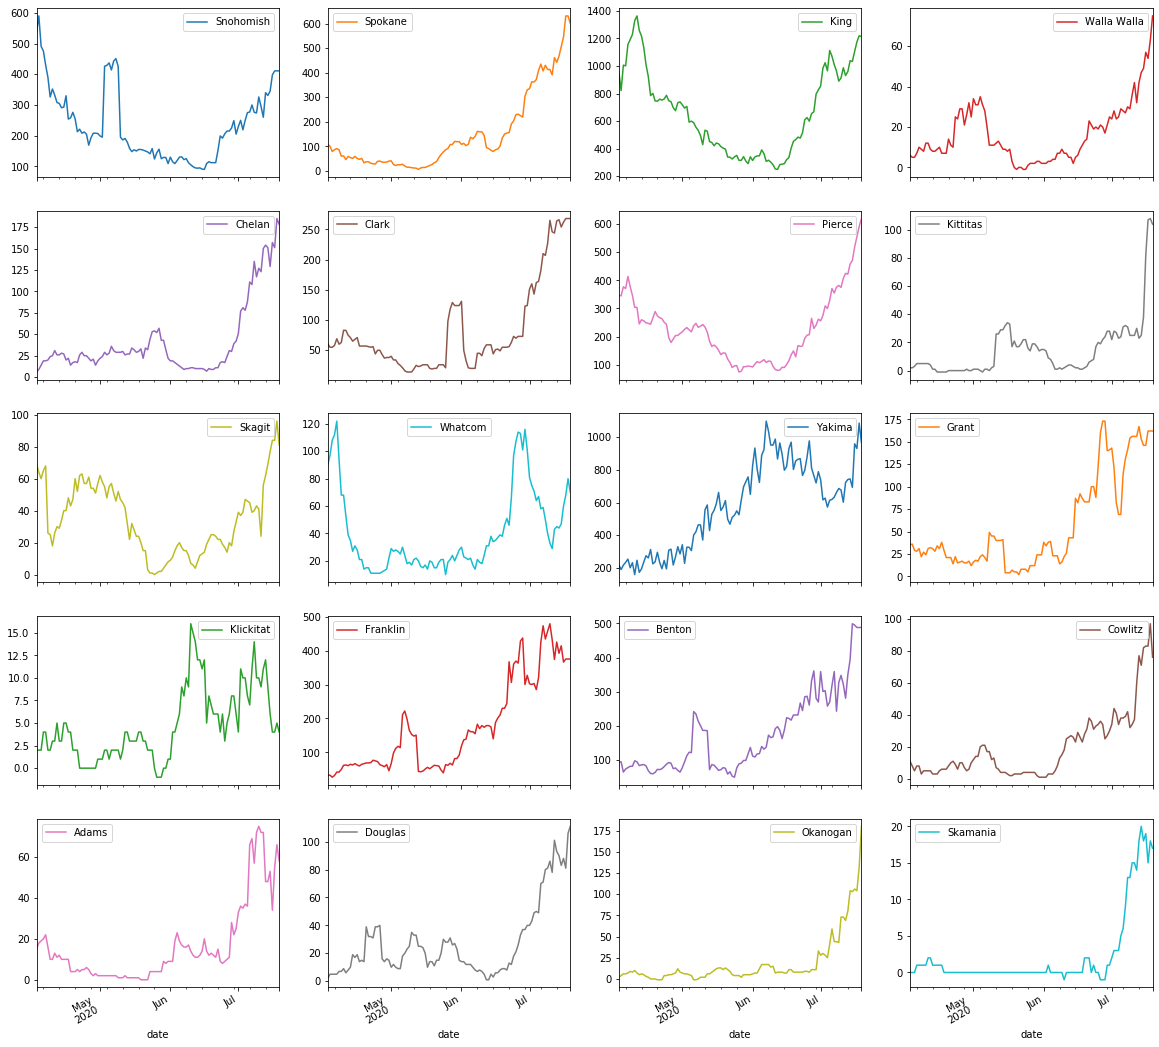

In [13]:
state = 'Washington'
cal = pd.DataFrame(wk_cases_county[state])
#select_top( wk_cases_county['California'], sum_list = 1, top = 10 )
worst_cases = select_top( cases_cty_thou[state], sum_list = 1, top = 20 )

top_10 = pd.DataFrame()
for cnty in worst_cases:
    top_10[cnty] = wk_cases_county[state][cnty].dropna()
top_10.dropna(inplace = True)    
top_10.plot( subplots = True, layout = (5, 4), figsize = (20,20), sharex = True )
plt.show()